# Hands on Natural Language Processigh-Emotion Recognition  
### Md. Naim Hassan Saykat, Aloïs Vincent, Marija Brkic  


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [27]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/Colab Notebooks/HONLP/train-00000-of-00001.parquet'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('punkt_tab')
sns.set_style("darkgrid")
sns.set_context("notebook")
pd.set_option('display.precision', 2)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Uploading and analyzing data

In [29]:
df = pd.read_parquet(dataset_path)

In [30]:
print(df.info())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB
None


,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2


In [31]:
labels = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

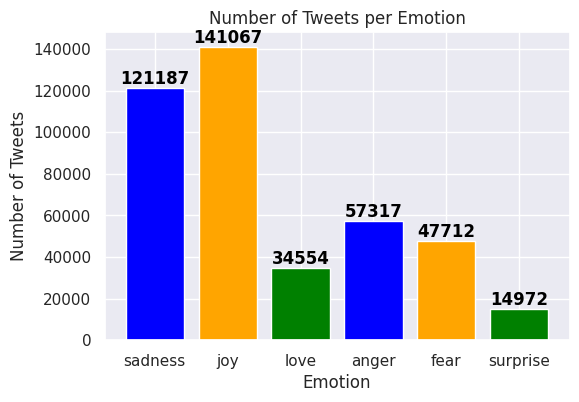

In [32]:
class_counts = df["label"].value_counts().sort_index()

plt.figure(figsize=(6, 4))
bars = plt.bar(class_counts.index.map(labels), class_counts.values, color=["blue", "orange", "green"])

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()),
             ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.xlabel("Emotion")
plt.ylabel("Number of Tweets")
plt.title("Number of Tweets per Emotion")
plt.xticks(rotation=0)
plt.show()

We can notice that classes are highly unbalanced.

count    416809.00
mean         97.03
std          56.20
min           2.00
25%          54.00
50%          86.00
75%         128.00
max         830.00
Name: char_count, dtype: float64


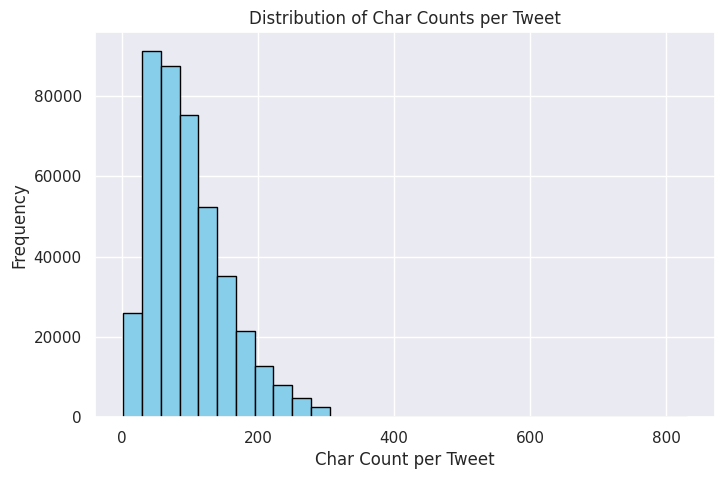

In [33]:
df["char_count"] = df["text"].apply(lambda x: len(x))

print(df["char_count"].describe())

plt.figure(figsize=(8, 5))
plt.hist(df["char_count"], bins=30, color="skyblue", edgecolor="black")
plt.xlabel("Char Count per Tweet")
plt.ylabel("Frequency")
plt.title("Distribution of Char Counts per Tweet")
plt.show()


<ipython-input-34-c070713e4195>:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(char_counts_per_class, labels=class_labels, patch_artist=True, boxprops=dict(facecolor="lightblue"))


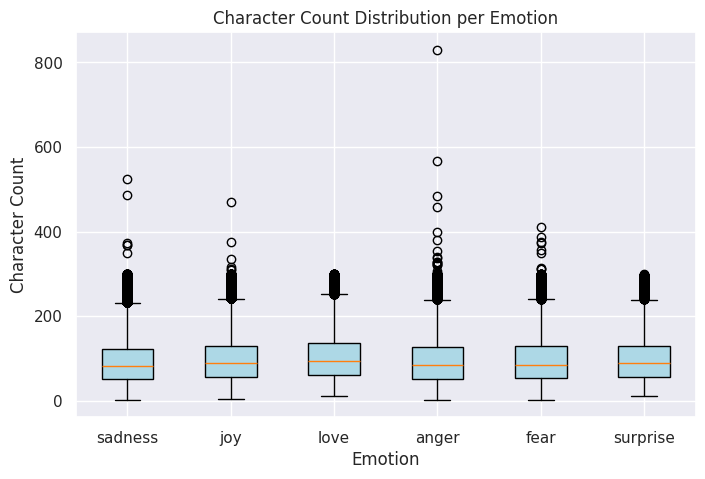

In [34]:
char_counts_per_class = [df[df["label"] == label]["char_count"] for label in sorted(df["label"].unique())]

class_labels = [labels[label] for label in sorted(df["label"].unique())]

plt.figure(figsize=(8, 5))
plt.boxplot(char_counts_per_class, labels=class_labels, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.xlabel("Emotion")
plt.ylabel("Character Count")
plt.title("Character Count Distribution per Emotion")
plt.show()


In [35]:
longest_tweets = df[df["char_count"]>400]
for _, row in longest_tweets.iterrows():
    print("\nTweet:\n")
    print(labels[row["label"]])
    print("\n")
    print(row["text"])


Tweet:

sadness


i have been thinking of changing my major for a few months my original major was chinese language and it blocks my way i have to face many problems at the sametime and i do not know what is real and virtuous i do not know if i am not interested in chinese or if there are other factors which make me sad i am not very clear on what i can do for the study of communication and journalism i am not clear about what i can do what are the limitations i hesitate but i feel more adjusted now

Tweet:

anger


i worked with several classmates on a project i was very anxious about the project while my partners showed no concern and when we had meetings on the project my classmates did not pay any attention some of them read books while the others argued on irrelevant questions the meeting would go on for two hours without the main theme being discussed we wasted time and could not reach a compromise my classmates avoided doing the work and the responsibilities

Tweet:

joy


i ha

We can notice that most of the classes have some outliers(very long tweets). Since the length of tweet might not be very influential in feeling prediction, but specific words(if we want to use N-Grams as features), long text lines could skew the visualization and the predictions.  
Furthermore, if we take a look at the longest tweets it seems they are long because they are a stories of certain situations. Therefore we decided that it would be reasonable to remove outliers. All texts that have length over 400 will be removed.

In [36]:
df = df[df["char_count"]<=400]

<ipython-input-37-c070713e4195>:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(char_counts_per_class, labels=class_labels, patch_artist=True, boxprops=dict(facecolor="lightblue"))


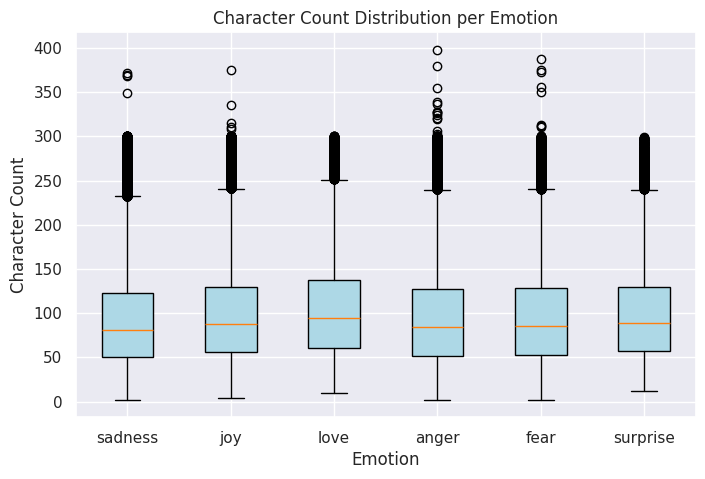

In [37]:
char_counts_per_class = [df[df["label"] == label]["char_count"] for label in sorted(df["label"].unique())]

class_labels = [labels[label] for label in sorted(df["label"].unique())]

plt.figure(figsize=(8, 5))
plt.boxplot(char_counts_per_class, labels=class_labels, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.xlabel("Emotion")
plt.ylabel("Character Count")
plt.title("Character Count Distribution per Emotion")
plt.show()

In [38]:
df['tokens'] = df['text'].apply(word_tokenize)
df.head(5)

,text,label,char_count,tokens
0,i feel awful about it too because it s my job ...,0,112,"[i, feel, awful, about, it, too, because, it, ..."
1,im alone i feel awful,0,21,"[im, alone, i, feel, awful]"
2,ive probably mentioned this before but i reall...,1,152,"[ive, probably, mentioned, this, before, but, ..."
3,i was feeling a little low few days back,0,40,"[i, was, feeling, a, little, low, few, days, b..."
4,i beleive that i am much more sensitive to oth...,2,99,"[i, beleive, that, i, am, much, more, sensitiv..."


In [39]:
df['types'] = df.tokens.map(set)
df['types_count'] = df.types.map(len)
df.head(5)

,text,label,char_count,tokens,types,types_count
0,i feel awful about it too because it s my job ...,0,112,"[i, feel, awful, about, it, too, because, it, ...","{too, get, a, happen, s, in, and, feel, t, bec...",23
1,im alone i feel awful,0,21,"[im, alone, i, feel, awful]","{i, feel, alone, im, awful}",5
2,ive probably mentioned this before but i reall...,1,152,"[ive, probably, mentioned, this, before, but, ...","{years, goals, probably, and, new, before, fee...",26
3,i was feeling a little low few days back,0,40,"[i, was, feeling, a, little, low, few, days, b...","{i, few, feeling, back, a, low, was, days, lit...",9
4,i beleive that i am much more sensitive to oth...,2,99,"[i, beleive, that, i, am, much, more, sensitiv...","{peoples, and, i, beleive, that, sensitive, to...",15


<ipython-input-40-52805ad3dc7a>:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(types_counts_per_class, labels=class_labels, patch_artist=True, boxprops=dict(facecolor="lightblue"))


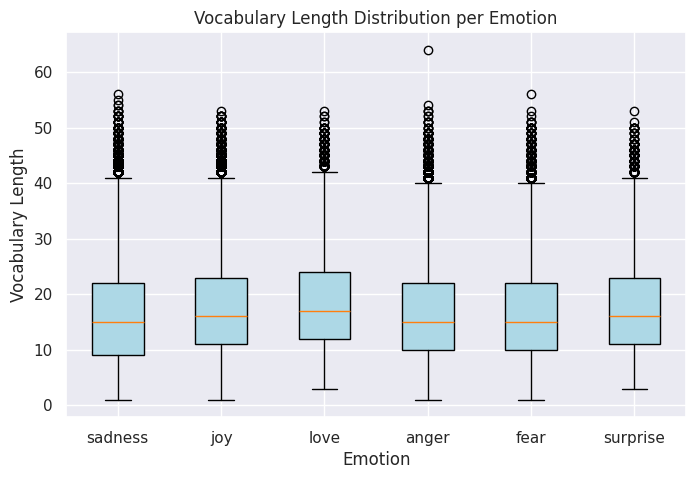

In [40]:
types_counts_per_class = [df[df["label"] == label]["types_count"] for label in sorted(df["label"].unique())]

class_labels = [labels[label] for label in sorted(df["label"].unique())]

plt.figure(figsize=(8, 5))
plt.boxplot(types_counts_per_class, labels=class_labels, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.xlabel("Emotion")
plt.ylabel("Vocabulary Length")
plt.title("Vocabulary Length Distribution per Emotion")
plt.show()

We can notice that all classes mostly have the same length vocabulary. There is a slight outlier in the class 'anger', but that means that there is one tweet with the largest number of unique tokens but the number is not significantly larger than the rest and we will not remove it from the dataset.

<ipython-input-41-bdd6a49529cc>:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(uniq_per_class, labels=class_labels, patch_artist=True, boxprops=dict(facecolor="lightblue"))


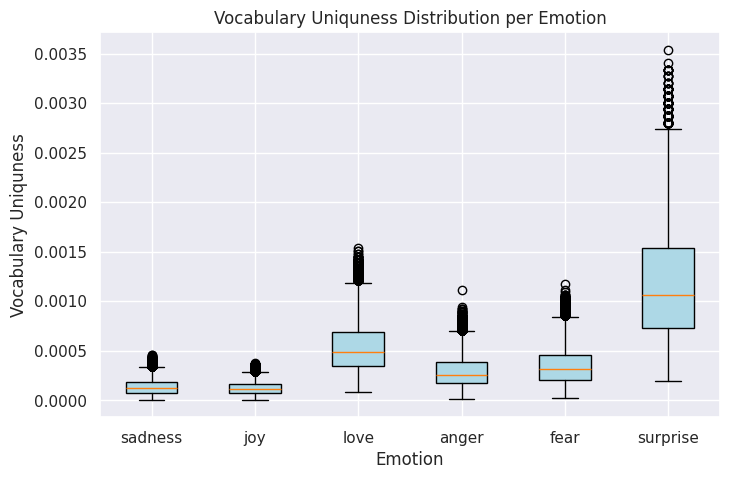

In [41]:
uniq_per_class = [df[df["label"] == label]["types_count"]/len(df[df["label"] == label]["types"]) for label in sorted(df["label"].unique())]

class_labels = [labels[label] for label in sorted(df["label"].unique())]

plt.figure(figsize=(8, 5))
plt.boxplot(uniq_per_class, labels=class_labels, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.xlabel("Emotion")
plt.ylabel("Vocabulary Uniquness")
plt.title("Vocabulary Uniquness Distribution per Emotion")
plt.show()

The previous boxplot shows the percentage of unique tokens in each tweet separated in classes. We can notice that 'surprise' has a significantly larger percentage of unique tokens, than the rest of the classes, which means it is by far the richest in the vocabulary, which absolutely makes sense because it is the smallest class.

In [42]:
all_tokens = [word for tokens in df["tokens"] for word in tokens]
token_freq = Counter(all_tokens)
token_df = pd.DataFrame(token_freq.items(), columns=["token", "frequency"])
token_df = token_df.sort_values(by="frequency", ascending=False).reset_index(drop=True)
token_df


,token,frequency
0,i,676149
1,feel,289936
2,and,250251
3,to,233087
4,the,216591
...,...,...
75289,galleryimageborder,1
75290,danbo,1
75291,truc,1
75292,entrails,1


In [18]:
import string

def count_punctuation(tokens):
    return sum(1 for token in tokens if token in string.punctuation)

punctuations = df["tokens"].apply(count_punctuation)

print(punctuations.unique())

[0]


The dataset doesn't have any punctuations.

As it was expected, the most frequent words are 'I' and 'feel', as well as the most common stop words. This means that we might be able to exclude all of them from the data.

## Vectorization and visualization

In [19]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features = 1000)
xs_tf_idf = vectorizer.fit_transform(df.text).toarray()

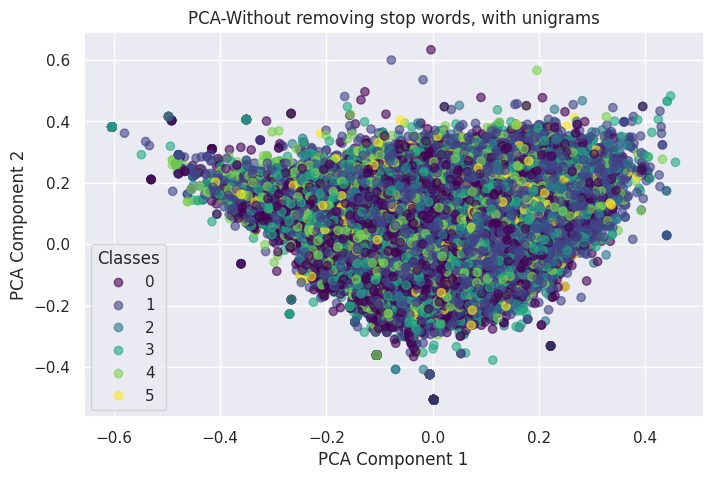

In [20]:

X_train, X_test, y_train, y_test = train_test_split(xs_tf_idf, df['label'], test_size=0.2, random_state=42)

pca = PCA(n_components=2)
reduced_data_pca_train = pca.fit_transform(X_train)

reduced_data_pca_test = pca.transform(X_test)


plt.figure(figsize=(8, 5))
scatter = plt.scatter(reduced_data_pca_train[:, 0], reduced_data_pca_train[:, 1], c=y_train, cmap='viridis', alpha=0.6)

plt.title("PCA-Without removing stop words, with unigrams")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.legend(handles=scatter.legend_elements()[0], labels=[str(i) for i in sorted(y_train.unique())], title="Classes")

plt.show()


The classes are not very well separated in the case with no stop words removingm and with unigrams.

In [21]:
vectorizer_sw = TfidfVectorizer(ngram_range=(1,1), stop_words = "english", max_features = 1000)
xs_tf_idf_sw = vectorizer_sw.fit_transform(df.text).toarray()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


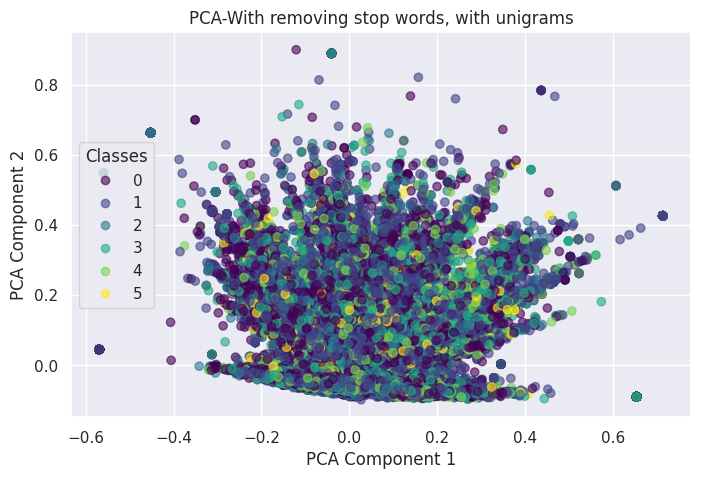

In [22]:
X_train_sw, X_test_sw, y_train_sw, y_test_sw = train_test_split(xs_tf_idf_sw, df['label'], test_size=0.2, random_state=42)

pca = PCA(n_components=2)
reduced_data_pca_train_sw = pca.fit_transform(X_train_sw)

reduced_data_pca_test_sw = pca.transform(X_test_sw)


plt.figure(figsize=(8, 5))
scatter = plt.scatter(reduced_data_pca_train_sw[:, 0], reduced_data_pca_train_sw[:, 1], c=y_train_sw, cmap='viridis', alpha=0.6)

plt.title("PCA-With removing stop words, with unigrams")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.legend(handles=scatter.legend_elements()[0], labels=[str(i) for i in sorted(y_train_sw.unique())], title="Classes")

plt.show()

Removing stop words did not help much with separation, but we can notice slight clustering of class '0' on the left side, and classes '3' and '4' on the right side.  
Moreover, it would make perfect sense to remove stop wordsm and we will be using that approach in the further analysis, but we will use 100 features in PCA.

In [23]:
pca = PCA(n_components=100)
X_train_sw = pca.fit_transform(X_train_sw)
X_test_sw = pca.transform(X_test_sw)

### Convolutional Neural Network after PCA

In [24]:
X_train_sw, X_val_sw, y_train_sw, y_val_sw = train_test_split(X_train_sw, y_train_sw, test_size=0.2, random_state=42)

We make train and validation split as well.

In [40]:
X_train_sw_reshaped = X_train_sw.reshape(X_train_sw.shape[0], X_train_sw.shape[1], 1)
X_test_sw_reshaped = X_test_sw.reshape(X_test_sw.shape[0], X_test_sw.shape[1], 1)
X_val_sw_reshaped = X_val_sw.reshape(X_val_sw.shape[0], X_val_sw.shape[1], 1)

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [29]:
class_weight_dict = compute_class_weight('balanced', classes=np.unique(y_train_sw), y=y_train_sw)
class_weight_dict = dict(enumerate(class_weight_dict))

In [38]:
X_train_sw_reshaped.shape

(266752, 1, 100)

In [49]:
model = Sequential([
    Conv1D(128, 3, activation='relu', input_shape=(X_train_sw_reshaped.shape[1], X_train_sw_reshaped.shape[2])),
    MaxPooling1D(pool_size=2),

    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(pool_size=2),

    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(pool_size=2),

    Flatten(),

    Dense(32, activation='relu'),
    Dropout(0.5),

    Dense(len(np.unique(y_train_sw)), activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

In [51]:
history = model.fit(X_train_sw_reshaped, y_train_sw,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val_sw_reshaped, y_val_sw),
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping],
                    verbose=1
                    )

Epoch 1/20
8336/8336 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.2956 - loss: 1.6384 - val_accuracy: 0.4553 - val_loss: 1.3634
Epoch 2/20
8336/8336 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.4117 - loss: 1.3650 - val_accuracy: 0.4776 - val_loss: 1.3166
Epoch 3/20
8336/8336 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.4280 - loss: 1.3085 - val_accuracy: 0.4961 - val_loss: 1.2889
Epoch 4/20
8336/8336 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.4392 - loss: 1.2789 - val_accuracy: 0.4898 - val_loss: 1.2591
Epoch 5/20
8336/8336 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.4484 - loss: 1.2600 - val_accuracy: 0.5207 - val_loss: 1.2065
Epoch 6/20
8336/8336 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.4523 - loss: 1.2450 - val_accuracy: 0.5147 - val_loss: 1.2083
Epoch 7/20
8336/8336 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.4572 - loss: 1.2367 - val_accuracy: 0.5312 - val_loss: 1.1817
Epoch 8/20
8336/8336 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.4603 - loss: 1

### Convolutional Neural Network without PCA  
We will be balancing the classes.

In [18]:
vectorizer_sw = TfidfVectorizer(ngram_range=(1,1), stop_words = "english", max_features = 5000)
xs_tf_idf_sw = vectorizer_sw.fit_transform(df.text).toarray()
X_train_sw, X_test_sw, y_train_sw, y_test_sw = train_test_split(xs_tf_idf_sw, df['label'], test_size=0.2, random_state=42)
X_train_sw, X_val_sw, y_train_sw, y_val_sw = train_test_split(X_train_sw, y_train_sw, test_size=0.2, random_state=42)

In [19]:
X_train_sw_reshaped = X_train_sw.reshape(X_train_sw.shape[0], X_train_sw.shape[1], 1)
X_test_sw_reshaped = X_test_sw.reshape(X_test_sw.shape[0], X_test_sw.shape[1], 1)
X_val_sw_reshaped = X_val_sw.reshape(X_val_sw.shape[0], X_val_sw.shape[1], 1)

In [22]:
class_weight_dict = compute_class_weight('balanced', classes=np.unique(y_train_sw), y=y_train_sw)
class_weight_dict = dict(enumerate(class_weight_dict))

In [23]:
model = Sequential([
    Conv1D(128, 3, activation='relu', input_shape=(X_train_sw_reshaped.shape[1], X_train_sw_reshaped.shape[2])),
    MaxPooling1D(pool_size=2),

    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(pool_size=2),

    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(pool_size=2),

    Conv1D(16, 3, activation='relu'),
    MaxPooling1D(pool_size=2),

    Flatten(),

    Dense(32, activation='relu'),
    Dropout(0.5),

    Dense(len(np.unique(y_train_sw)), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

In [25]:
history = model.fit(X_train_sw_reshaped, y_train_sw,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val_sw_reshaped, y_val_sw),
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping],
                    verbose=1
                    )

Epoch 1/20
8336/8336 ━━━━━━━━━━━━━━━━━━━━ 282s 33ms/step - accuracy: 0.6321 - loss: 0.8897 - val_accuracy: 0.8746 - val_loss: 0.3137
Epoch 2/20
8336/8336 ━━━━━━━━━━━━━━━━━━━━ 275s 33ms/step - accuracy: 0.8470 - loss: 0.3579 - val_accuracy: 0.8801 - val_loss: 0.2829
Epoch 3/20
8336/8336 ━━━━━━━━━━━━━━━━━━━━ 272s 33ms/step - accuracy: 0.8594 - loss: 0.3149 - val_accuracy: 0.8831 - val_loss: 0.2786
Epoch 4/20
8336/8336 ━━━━━━━━━━━━━━━━━━━━ 272s 33ms/step - accuracy: 0.8668 - loss: 0.2893 - val_accuracy: 0.8828 - val_loss: 0.2787
Epoch 5/20
8336/8336 ━━━━━━━━━━━━━━━━━━━━ 272s 33ms/step - accuracy: 0.8707 - loss: 0.2741 - val_accuracy: 0.8863 - val_loss: 0.2643
Epoch 6/20
8336/8336 ━━━━━━━━━━━━━━━━━━━━ 272s 33ms/step - accuracy: 0.8711 - loss: 0.2677 - val_accuracy: 0.8800 - val_loss: 0.2764
Epoch 7/20
8336/8336 ━━━━━━━━━━━━━━━━━━━━ 273s 33ms/step - accuracy: 0.8738 - loss: 0.2586 - val_accuracy: 0.8850 - val_loss: 0.2610
Epoch 8/20
8336/8336 ━━━━━━━━━━━━━━━━━━━━ 273s 33ms/step - accuracy: 

In [44]:
y_pred = model.predict(X_test_sw_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step


In [45]:
from sklearn.metrics import classification_report, confusion_matrix

In [46]:
print(classification_report(y_test_sw, y_pred_classes))

              precision    recall  f1-score   support

           0       0.96      0.89      0.93     24400
           1       0.96      0.86      0.91     28242
           2       0.72      0.95      0.82      6872
           3       0.88      0.91      0.89     11389
           4       0.83      0.86      0.85      9451
           5       0.64      0.96      0.77      3007

    accuracy                           0.89     83361
   macro avg       0.83      0.91      0.86     83361
weighted avg       0.90      0.89      0.89     83361



We can notice that the best predicted classes are joy('0') and sadness('1'), and the worst classified one is surprise ('5'). Even though the surprise was the richest class in tokens, it is still the smallest class, while joy and sadness are the biggest ones. We tried to use class weights in order to balance classes, but this problem obviously still had an impact on classification.

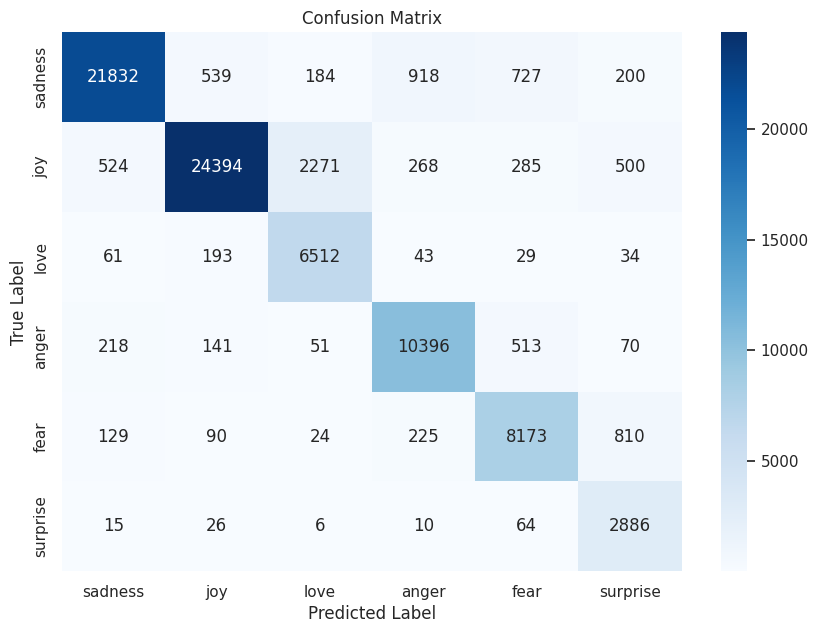

In [49]:
conf_matrix = confusion_matrix(y_test_sw, y_pred_classes)

labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


$$Recall = \frac{TP}{TP+FN}$$  
$$Precission = \frac{TP}{TP+FP}$$  


The same thing could be noticed in the confusion matrix. It is also very interesting to mention that a lot of joy was classified as love, which could be understandable, because they are similar emotions.

In [50]:
misclassified_idx = np.where(y_test_sw != y_pred_classes)[0]

for i in range(5):
    idx = misclassified_idx[i]
    print(f"Text: {df.text.iloc[idx]}")
    print(f"True Label: {labels[y_test_sw.iloc[idx]]}")
    print(f"Predicted Label: {labels[y_pred_classes[idx]]}")
    print("-" * 80)

Text: i was feeling a little low few days back
True Label: fear
Predicted Label: surprise
--------------------------------------------------------------------------------
Text: i don t feel comfortable around you
True Label: fear
Predicted Label: surprise
--------------------------------------------------------------------------------
Text: i am only having day a week where i am feeling depressed or seriously anxious
True Label: sadness
Predicted Label: fear
--------------------------------------------------------------------------------
Text: i feel myself relax a little he wouldn t be this friendly if he was going to tear me off a strip but my mind is working overtime trying to work out what he does want
True Label: joy
Predicted Label: love
--------------------------------------------------------------------------------
Text: ive been feeling pretty shitty and been in a pretty shitty mood the past few days
True Label: joy
Predicted Label: love
---------------------------------------

All of the presented wrongly classified instances are classified as very similar emotion, and in these instances even a human could make a mistake. Furthermore, even some labels are questionable.

## Traditional models, BERT, Ensamble

In [ ]:
# Load the Dataset

from datasets import load_dataset

# Load the emotion dataset
dataset = load_dataset("dair-ai/emotion")



In [41]:
# BERT-based transformers model

from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
# Tokenize the Data

from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Apply tokenization
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Print a sample
print(tokenized_datasets["train"][0])

{'text': 'i didnt feel humiliated', 'label': 0, 'input_ids': [101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [43]:
# Handle Class Imbalance

from collections import Counter
import torch

# Count label distribution in training data
labels = dataset["train"]["label"]
label_counts = Counter(labels)

# Compute class weights
num_samples = len(labels)
num_classes = len(label_counts)
class_weights = [num_samples / (num_classes * count) for count in label_counts.values()]
class_weights_tensor = torch.tensor(class_weights)

print(f"Class Weights: {class_weights}")

Class Weights: [0.5715102157451064, 1.2351397251814111, 2.044989775051125, 4.662004662004662, 1.3766993632765445, 0.49732686808404825]


In [44]:
# Define Training Arguments & Trainer

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Evaluate after every epoch
    save_strategy="epoch",  # Save best model at the end
    learning_rate=1e-5,  # Lower learning rate improves generalization
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,  # Train for longer
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
)

In [45]:
# Train the model

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.323400,0.228848
2,0.173700,0.177630
3,0.121600,0.178826
4,0.106800,0.176363
5,0.077600,0.184593


TrainOutput(global_step=5000, training_loss=0.22754581909179689, metrics={'train_runtime': 18753.6454, 'train_samples_per_second': 4.266, 'train_steps_per_second': 0.267, 'total_flos': 2.104964038656e+16, 'train_loss': 0.22754581909179689, 'epoch': 5.0})

In [132]:
# Evaluate the Model on Test Data

import evaluate

# Load accuracy metric
metric = evaluate.load("accuracy")

# Get model predictions
predictions = trainer.predict(tokenized_datasets["test"])
preds = predictions.predictions.argmax(-1)

# Compute accuracy
accuracy = metric.compute(predictions=preds, references=tokenized_datasets["test"]["label"])
print(f"Test Accuracy: {accuracy['accuracy']:.4f}")

Test Accuracy: 0.9205


In [133]:
# Improve Model Generalization (Fix Overfitting)

from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]  # Stop if no improvement after 1 epoch
)

In [134]:
# Apply Dropout Regularization in the model

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6, hidden_dropout_prob=0.3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [135]:
# Analyze Model Errors (Classification Report)

from sklearn.metrics import classification_report

labels = tokenized_datasets["test"]["label"]
print(classification_report(labels, preds, target_names=["sadness", "joy", "love", "anger", "fear", "surprise"]))

              precision    recall  f1-score   support

     sadness       0.96      0.96      0.96       581
         joy       0.95      0.95      0.95       695
        love       0.83      0.81      0.82       159
       anger       0.93      0.90      0.91       275
        fear       0.86      0.88      0.87       224
    surprise       0.70      0.77      0.73        66

    accuracy                           0.92      2000
   macro avg       0.87      0.88      0.87      2000
weighted avg       0.92      0.92      0.92      2000



In [145]:
# Analyze Misclassifications

import pandas as pd

# Convert test data to DataFrame
df_test = dataset["test"].to_pandas()
df_test["predictions"] = preds

# Show misclassified examples
misclassified = df_test[df_test["label"] != df_test["predictions"]]
print(misclassified.sample(10))

                                                   text  label  predictions
1479  i really feel and i know the devil hates that ...      1            3
457   i cant do strappy shoes at work i just feel we...      4            5
917   i feel the need to pimp this since raini my be...      1            2
1936  im polyamorous something im starting to feel t...      2            1
863   i feel betrayed and angry and sad at the same ...      3            0
1764  i don t know how else to describe it except to...      1            2
820            i found myself feeling a bit overwhelmed      5            4
625   i am feeling overwhelmed by trying to do it al...      5            4
1087  i feel for all of you who have been supporting...      1            2
688                             i feel hated in cempaka      0            3


In [50]:
# Save the Model for Deployment

trainer.save_model("./best_emotion_model")
tokenizer.save_pretrained("./best_emotion_model")

('./best_emotion_model/tokenizer_config.json',
 './best_emotion_model/special_tokens_map.json',
 './best_emotion_model/vocab.txt',
 './best_emotion_model/added_tokens.json',
 './best_emotion_model/tokenizer.json')

In [152]:
# To reload the best model later

from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("./best_emotion_model")
tokenizer = AutoTokenizer.from_pretrained("./best_emotion_model")

In [153]:
# Test on Custom Sentences

texts = ["I'm feeling really down today.", "Wow! This is amazing!", "I am so scared to go outside."]

# Tokenize and predict
inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
outputs = model(**inputs)
predictions = outputs.logits.argmax(-1)

# Print predictions
for text, pred in zip(texts, predictions):
    print(f"Text: {text} → Predicted Emotion: {tokenized_datasets['train'].features['label'].int2str(pred.item())}")

Text: I'm feeling really down today. → Predicted Emotion: sadness
Text: Wow! This is amazing! → Predicted Emotion: surprise
Text: I am so scared to go outside. → Predicted Emotion: fear


In [154]:
# Extract Logits Before Applying argmax()

import torch

def predict_emotion(text):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Move model and input to the correct device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokenize input text
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)

    # Get model output
    with torch.no_grad():  # Disable gradient calculations for inference
        output = model(**tokens)  # Correct way to pass inputs to transformer models

    # Extract logits and apply argmax to get the predicted label index
    logits = output.logits  # Extract logits
    prediction = torch.argmax(logits, dim=1).item()  # Get the highest probability class

    # Emotion labels
    emotion_labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

    return emotion_labels[prediction]

# Example Predictions
print(predict_emotion("I am feeling very happy today!"))  # Expected: Joy
print(predict_emotion("I'm so scared of what will happen next."))  # Expected: Fear
print(predict_emotion("This is the worst day of my life."))  # Expected: Sadness
print(predict_emotion("Wow, this is amazing!"))  # Expected: Surprise

joy
fear
sadness
surprise


In [ ]:
# Convert Text to TF-IDF Features

from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text data into TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 features for efficiency
X_train = vectorizer.fit_transform(df_train["text"])
X_test = vectorizer.transform(df_test["text"])

# Extract labels
y_train = df_train["label"]
y_test = df_test["label"]



In [129]:
# Train & Evaluate the Support Vector Machine (SVM) on Test Data

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train SVM model
svm_model = SVC(kernel="linear")
svm_model.fit(X_train, y_train)

# Predict and evaluate
svm_preds = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, svm_preds)

print(f"SVM Accuracy: {svm_acc:.4f}")

SVM Accuracy: 0.8870


In [166]:
# SVM Classification Report
 
print("Classification Report for SVM:")
print(classification_report(y_test, svm_preds, target_names=["sadness", "joy", "love", "anger", "fear", "surprise"]))

Classification Report for SVM:
              precision    recall  f1-score   support

     sadness       0.93      0.92      0.93       581
         joy       0.88      0.95      0.91       695
        love       0.82      0.69      0.75       159
       anger       0.89      0.88      0.88       275
        fear       0.85      0.86      0.86       224
    surprise       0.74      0.56      0.64        66

    accuracy                           0.89      2000
   macro avg       0.85      0.81      0.83      2000
weighted avg       0.89      0.89      0.88      2000



In [147]:
# Analyze Misclassifications for SVM

import pandas as pd

# Convert test data to DataFrame
df_test_svm = dataset["test"].to_pandas()

# Add SVM Predictions to the DataFrame
df_test_svm["svm_predictions"] = svm_model.predict(X_test_tfidf)

# Show misclassified examples
misclassified_svm = df_test_svm[df_test_svm["label"] != df_test_svm["svm_predictions"]]

# Display random 10 misclassified examples
print("Misclassified Examples (SVM Model):")
print(misclassified_svm.sample(10))

Misclassified Examples (SVM Model):
                                                   text  label  \
103   i feel agitated with myself that i did not for...      4   
1048  i wonder if the homeowners would feel weird if...      5   
501   when we rearranged furniture in our flat and g...      3   
1592        i have strong feelings about being faithful      2   
575   i feel not having a generous spirit or a forgi...      2   
625   i am feeling overwhelmed by trying to do it al...      5   
1928  i feel inside cause life is like a game someti...      4   
1296         i that it feels like she is being tortured      4   
869   i feel like if people accepted that wed get al...      2   
823   i dont remember how january was like last year...      3   

      svm_predictions  
103                 3  
1048                4  
501                 1  
1592                1  
575                 1  
625                 4  
1928                0  
1296                3  
869                 1

In [173]:
# Test on Custom Sentences for SVM

# Define custom sentences
custom_texts = [
    "I am feeling very happy today!",
    "This is the worst day of my life.",
    "I can't stop smiling, this is the best surprise ever!",
    "I am so scared to go outside alone.",
    "I feel so loved and appreciated today.",
    "Why do you always make me so angry?",
    "I feel like crying all day long."
]

# Transform custom sentences using the same TF-IDF vectorizer
custom_tfidf_features = tfidf_vectorizer.transform(custom_texts)

# Predict using SVM
svm_custom_preds = svm_model.predict(custom_tfidf_features)

# Emotion Labels Mapping
emotion_labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

# Convert predictions to emotion labels
svm_custom_preds_labels = [emotion_labels[pred] for pred in svm_custom_preds]

# Print Predictions
print("Custom Sentence Predictions (SVM):\n")
for text, pred_label in zip(custom_texts, svm_custom_preds_labels):
    print(f"Sentence: {text}")
    print(f"SVM Prediction: {pred_label}\n")

Custom Sentence Predictions (SVM):

Sentence: I am feeling very happy today!
SVM Prediction: joy

Sentence: This is the worst day of my life.
SVM Prediction: joy

Sentence: I can't stop smiling, this is the best surprise ever!
SVM Prediction: joy

Sentence: I am so scared to go outside alone.
SVM Prediction: fear

Sentence: I feel so loved and appreciated today.
SVM Prediction: love

Sentence: Why do you always make me so angry?
SVM Prediction: anger

Sentence: I feel like crying all day long.
SVM Prediction: joy



In [164]:
# Extract Logits Before Applying argmax() to SVM

import numpy as np

def predict_emotion_svm(text):
    """
    Function to predict the emotion using the trained SVM model.
    Extracts logits (decision function values) before applying argmax().
    """
    # Transform input text using the same TF-IDF vectorizer
    text_tfidf = tfidf_vectorizer.transform([text])

    # Get model output (decision function for probabilities)
    logits = svm_model.decision_function(text_tfidf)

    # Apply argmax to get the predicted label index
    prediction = np.argmax(logits)

    # Emotion labels
    emotion_labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

    return emotion_labels[prediction], logits  # Returning logits along with prediction

# Example Predictions with Logits for SVM
custom_sentences = [
    "I am feeling very happy today!",  # Expected: Joy
    "I'm so scared of what will happen next.",  # Expected: Fear
    "This is the worst day of my life.",  # Expected: Sadness
    "Wow, this is amazing!"  # Expected: Surprise
]  

# Make predictions and extract logits
print("SVM Predictions with Logits:\n")
for text in custom_sentences:
    prediction, logits = predict_emotion_svm(text)
    print(f"Sentence: {text}")
    print(f"SVM Prediction: {prediction}")
    print(f"Logits: {logits}\n")  # Raw model decision values

SVM Predictions with Logits:

Sentence: I am feeling very happy today!
SVM Prediction: joy
Logits: [[ 4.21734192  5.29313949  0.75707932  2.84660651  1.83615835 -0.27445076]]

Sentence: I'm so scared of what will happen next.
SVM Prediction: fear
Logits: [[ 4.13534549  2.99247187  0.7420411   1.8344909   5.29496232 -0.26584384]]

Sentence: This is the worst day of my life.
SVM Prediction: joy
Logits: [[ 4.22671562  5.25770218  0.76205444  3.21362757  1.8341     -0.2643637 ]]

Sentence: Wow, this is amazing!
SVM Prediction: joy
Logits: [[ 2.80986026  5.28427686 -0.27432975  1.75275479  0.74291711  4.28844537]]



In [165]:
# Train & Evaluate the Random Forest on Test Data

from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
rf_preds = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)

print(f"Random Forest Accuracy: {rf_acc:.4f}")

Random Forest Accuracy: 0.8725


In [80]:
# Random Forest Classification Report

print("Classification Report for Random Forest:")
print(classification_report(y_test, rf_preds, target_names=["sadness", "joy", "love", "anger", "fear", "surprise"]))

Random Forest Accuracy: 0.8800


In [168]:
# Analyze Misclassifications for Random Forest

import pandas as pd

# Convert test data to DataFrame
df_test_rf = dataset["test"].to_pandas()

# Add Random Forest Predictions to the DataFrame
df_test_rf["rf_predictions"] = rf_model.predict(X_test_tfidf)

# Show misclassified examples
misclassified_rf = df_test_rf[df_test_rf["label"] != df_test_rf["rf_predictions"]]

# Display random 10 misclassified examples
print("Misclassified Examples (Random Forest Model):")
print(misclassified_rf.sample(10))

Misclassified Examples (Random Forest Model):
                                                   text  label  rf_predictions
660   i was playing a sport in an advanced pe class ...      3               1
1530  i feel furious at love because i really though...      3               1
1146  i feel affirmed gracious sensuous and will hav...      2               1
119   i feel like i know who most of them are by now...      1               0
1402                     i just keep on feeling blessed      2               1
565   i feel like an ugly monster where i cannot sho...      0               4
1791  i did a body scan and realized that everything...      5               1
941   i still feel confused and guilty about the who...      4               0
466              i feel his hand on me to stay faithful      2               1
468                        i cant help feeling this way      0               1


In [171]:
# Test on Custom Sentences for Random Forest

# Define custom sentences
custom_texts = [
    "I am feeling very happy today!",
    "This is the worst day of my life.",
    "I can't stop smiling, this is the best surprise ever!",
    "I am so scared to go outside alone.",
    "I feel so loved and appreciated today.",
    "Why do you always make me so angry?",
    "I feel like crying all day long."
]

# Transform custom sentences using the same TF-IDF vectorizer
custom_tfidf_features = tfidf_vectorizer.transform(custom_texts)

# Predict using Random Forest
rf_custom_preds = rf_model.predict(custom_tfidf_features)

# Emotion Labels Mapping
emotion_labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

# Convert predictions to emotion labels
rf_custom_preds_labels = [emotion_labels[pred] for pred in rf_custom_preds]

# Print Predictions
print("Custom Sentence Predictions (Random Forest):\n")
for text, pred_label in zip(custom_texts, rf_custom_preds_labels):
    print(f"Sentence: {text}")
    print(f"Random Forest Prediction: {pred_label}\n")

Custom Sentence Predictions (Random Forest):

Sentence: I am feeling very happy today!
Random Forest Prediction: joy

Sentence: This is the worst day of my life.
Random Forest Prediction: joy

Sentence: I can't stop smiling, this is the best surprise ever!
Random Forest Prediction: joy

Sentence: I am so scared to go outside alone.
Random Forest Prediction: fear

Sentence: I feel so loved and appreciated today.
Random Forest Prediction: love

Sentence: Why do you always make me so angry?
Random Forest Prediction: anger

Sentence: I feel like crying all day long.
Random Forest Prediction: joy



In [175]:
# Extract Logits Before Applying argmax() to Random Forest

import numpy as np

def predict_emotion_rf(text):
    """
    Function to predict the emotion using the trained Random Forest model.
    Extracts logits (probabilities) before applying argmax().
    """
    # Transform input text using the same TF-IDF vectorizer
    text_tfidf = tfidf_vectorizer.transform([text])

    # Get model output (predict_proba gives probability distribution over classes)
    logits = rf_model.predict_proba(text_tfidf)[0]  # Extracting probabilities

    # Apply argmax to get the predicted label index
    prediction = np.argmax(logits)

    # Emotion labels
    emotion_labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

    return emotion_labels[prediction], logits  # Returning logits along with prediction

# Example Predictions with Logits for Random Forest
custom_sentences = [
    "I am feeling very happy today!",  # Expected: Joy
    "I'm so scared of what will happen next.",  # Expected: Fear
    "This is the worst day of my life.",  # Expected: Sadness
    "Wow, this is amazing!"  # Expected: Surprise
]  

# Make predictions and extract logits
print("Random Forest Predictions with Logits:\n")
for text in custom_sentences:
    prediction, logits = predict_emotion_rf(text)
    print(f"Sentence: {text}")
    print(f"RF Prediction: {prediction}")
    print(f"Logits (Probabilities): {logits}\n")  # Raw model probability values

Random Forest Predictions with Logits:

Sentence: I am feeling very happy today!
RF Prediction: joy
Logits (Probabilities): [0.1  0.76 0.05 0.06 0.03 0.  ]

Sentence: I'm so scared of what will happen next.
RF Prediction: fear
Logits (Probabilities): [0.13 0.05 0.01 0.02 0.79 0.  ]

Sentence: This is the worst day of my life.
RF Prediction: joy
Logits (Probabilities): [0.2  0.53 0.03 0.1  0.13 0.01]

Sentence: Wow, this is amazing!
RF Prediction: joy
Logits (Probabilities): [0.04 0.6  0.   0.02 0.   0.34]



In [187]:
# Train & Evaluate the Logistic Regression Model on Test Data

# Initialize Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)

# Train the model on TF-IDF features
log_reg_model.fit(X_train_tfidf, y_train)

# Predict on Test Data
log_reg_preds = log_reg_model.predict(X_test_tfidf)

# Evaluate the model
log_reg_accuracy = accuracy_score(y_test, log_reg_preds)
print(f"✅ Logistic Regression Test Accuracy: {log_reg_accuracy:.4f}")

✅ Logistic Regression Test Accuracy: 0.8690


In [182]:
# Classification Report for Logistic Regression

print("Classification Report for Logistic Regression:")
print(classification_report(y_test, lr_preds, target_names=["sadness", "joy", "love", "anger", "fear", "surprise"]))

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

     sadness       0.90      0.93      0.91       581
         joy       0.85      0.96      0.90       695
        love       0.82      0.62      0.71       159
       anger       0.89      0.83      0.86       275
        fear       0.88      0.79      0.83       224
    surprise       0.80      0.53      0.64        66

    accuracy                           0.87      2000
   macro avg       0.86      0.78      0.81      2000
weighted avg       0.87      0.87      0.87      2000



In [191]:
# Analyze Misclassifications for Logistic Regression Model

import pandas as pd

# Convert test dataset to Pandas DataFrame
df_test_log_reg = dataset["test"].to_pandas()

# Add Logistic Regression Predictions to the DataFrame
df_test_log_reg["log_reg_predictions"] = log_reg_model.predict(X_test_tfidf)

# Show misclassified examples
misclassified_log_reg = df_test_log_reg[df_test_log_reg["label"] != df_test_log_reg["log_reg_predictions"]]

# Display 10 randomly selected misclassified examples
print("Misclassified Examples (Logistic Regression Model):")
print(misclassified_log_reg.sample(10))

Misclassified Examples (Logistic Regression Model):
                                                   text  label  \
433   i know that i have it nowhere near as worse as...      4   
74    i were to go overseas or cross the border then...      2   
1936  im polyamorous something im starting to feel t...      2   
222   i think i wanted audiences to feel impressed i...      5   
96    i love neglecting this blog but sometimes i fe...      2   
715   i get to be creative if i feel like it or just...      2   
242   i see you on the pitchers mound at our little ...      4   
193   i really dont like quinn because i feel like s...      3   
1387  im not sure but theres nothing that will get a...      2   
121                        made a wonderfull new friend      1   

      log_reg_predictions  
433                     0  
74                      1  
1936                    1  
222                     1  
96                      1  
715                     1  
242                     0

In [193]:
# Test on Custom Sentences for Logistic Regression

# Define custom sentences
custom_texts = [
    "I am feeling very happy today!",
    "This is the worst day of my life.",
    "I can't stop smiling, this is the best surprise ever!",
    "I am so scared to go outside alone.",
    "I feel so loved and appreciated today.",
    "Why do you always make me so angry?",
    "I feel like crying all day long."
]

# Transform custom sentences using the same TF-IDF vectorizer
custom_tfidf_features = tfidf_vectorizer.transform(custom_texts)

# Predict using Logistic Regression
log_reg_custom_preds = log_reg_model.predict(custom_tfidf_features)

# Emotion Labels Mapping
emotion_labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

# Convert predictions to emotion labels
log_reg_custom_preds_labels = [emotion_labels[pred] for pred in log_reg_custom_preds]

# Print Predictions
print("Custom Sentence Predictions (Logistic Regression):\n")
for text, pred_label in zip(custom_texts, log_reg_custom_preds_labels):
    print(f"Sentence: {text}")
    print(f"Logistic Regression Prediction: {pred_label}\n")

Custom Sentence Predictions (Logistic Regression):

Sentence: I am feeling very happy today!
Logistic Regression Prediction: joy

Sentence: This is the worst day of my life.
Logistic Regression Prediction: joy

Sentence: I can't stop smiling, this is the best surprise ever!
Logistic Regression Prediction: joy

Sentence: I am so scared to go outside alone.
Logistic Regression Prediction: fear

Sentence: I feel so loved and appreciated today.
Logistic Regression Prediction: love

Sentence: Why do you always make me so angry?
Logistic Regression Prediction: anger

Sentence: I feel like crying all day long.
Logistic Regression Prediction: sadness



In [196]:
# Extract Logits Before Applying argmax() to Logistic Regression

import numpy as np

def predict_emotion_log_reg(text):
    """
    Function to predict the emotion using the trained Logistic Regression model.
    Extracts logits (probabilities) before applying argmax().
    """
    # Transform input text using the same TF-IDF vectorizer
    text_tfidf = tfidf_vectorizer.transform([text])

    # Get model output (predict_proba gives probability distribution over classes)
    logits = log_reg_model.predict_proba(text_tfidf)[0]  # Extracting probabilities

    # Apply argmax to get the predicted label index
    prediction = np.argmax(logits)

    # Emotion labels
    emotion_labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

    return emotion_labels[prediction], logits  # Returning logits along with prediction

# Example Predictions with Logits for Logistic Regression
custom_sentences = [
    "I am feeling very happy today!",  # Expected: Joy
    "I'm so scared of what will happen next.",  # Expected: Fear
    "This is the worst day of my life.",  # Expected: Sadness
    "Wow, this is amazing!"  # Expected: Surprise
]  

# Make predictions and extract logits
print("Logistic Regression Predictions with Logits:\n")
for text in custom_sentences:
    prediction, logits = predict_emotion_log_reg(text)
    print(f"Sentence: {text}")
    print(f"Logistic Regression Prediction: {prediction}")
    print(f"Logits (Probabilities): {logits}\n")  # Raw model probability values

Logistic Regression Predictions with Logits:

Sentence: I am feeling very happy today!
Logistic Regression Prediction: joy
Logits (Probabilities): [0.07556277 0.85000386 0.01456523 0.03092256 0.02330232 0.00564325]

Sentence: I'm so scared of what will happen next.
Logistic Regression Prediction: fear
Logits (Probabilities): [0.0754142  0.05694343 0.02117282 0.03144245 0.8017663  0.0132608 ]

Sentence: This is the worst day of my life.
Logistic Regression Prediction: joy
Logits (Probabilities): [0.28885688 0.39450347 0.06980073 0.14504974 0.07739482 0.02439436]

Sentence: Wow, this is amazing!
Logistic Regression Prediction: joy
Logits (Probabilities): [0.05419698 0.51559954 0.03195987 0.04481148 0.03571615 0.31771598]



In [224]:
# We can now combine train & evaluate the Bert, SVM, Random Forest, and Logistic Regression using a simple majority voting for an Ensemble Approach on Test Data

# Stack predictions from all models
predictions_stack = np.column_stack((svm_preds, rf_preds, log_reg_preds, bert_preds))

# Majority voting: select the most common prediction for each instance
ensemble_preds, _ = mode(predictions_stack, axis=1)
ensemble_preds = ensemble_preds.flatten()  # Convert to 1D array

# Evaluate ensemble accuracy
ensemble_acc = accuracy_score(y_test, ensemble_preds)

print(f"\nEnsemble Model Accuracy (BERT + SVM + RF + LR): {ensemble_acc:.4f}")


Ensemble Model Accuracy (BERT + SVM + RF + LR): 0.8980


In [225]:
# Ensemble Model Classification Report (Bert, SVM, Random Forest, and Logistic Regression)

print("\nEnsemble Model Classification Report:")
print(classification_report(y_test, ensemble_preds, target_names=["sadness", "joy", "love", "anger", "fear", "surprise"]))


Ensemble Model Classification Report:
              precision    recall  f1-score   support

     sadness       0.93      0.96      0.94       581
         joy       0.88      0.97      0.92       695
        love       0.84      0.64      0.73       159
       anger       0.93      0.87      0.90       275
        fear       0.87      0.86      0.87       224
    surprise       0.87      0.50      0.63        66

    accuracy                           0.90      2000
   macro avg       0.89      0.80      0.83      2000
weighted avg       0.90      0.90      0.89      2000



In [226]:
# Analyze Misclassifications for Ensemble Model (Bert, SVM, Random Forest, and Logistic Regression)

# Convert test dataset to Pandas DataFrame
df_test_ensemble = dataset["test"].to_pandas()

# Get predictions from individual models
svm_preds = svm_model.predict(X_test_tfidf)
rf_preds = rf_model.predict(X_test_tfidf)
log_reg_preds = log_reg_model.predict(X_test_tfidf)

# Get predictions from the BERT model
bert_preds = trainer.predict(tokenized_datasets["test"]).predictions.argmax(-1)

# Perform Majority Voting for Ensemble Prediction
ensemble_preds = np.array([svm_preds, rf_preds, log_reg_preds, bert_preds])  # Stack predictions
final_ensemble_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=ensemble_preds)

# Add Ensemble Predictions to the DataFrame
df_test_ensemble["ensemble_predictions"] = final_ensemble_preds

# Show misclassified examples
misclassified_ensemble = df_test_ensemble[df_test_ensemble["label"] != df_test_ensemble["ensemble_predictions"]]

# Display 10 randomly selected misclassified examples
print("Misclassified Examples (Ensemble Model - BERT + SVM + RF + Logistic Regression):")
print(misclassified_ensemble.sample(10))

Misclassified Examples (Ensemble Model - BERT + SVM + RF + Logistic Regression):
                                                   text  label  \
693   i can say is that as long as you enjoy the sto...      0   
1533  i actually was in a meeting last week where so...      3   
1714           i also do feel passionate about teaching      2   
206   i wish to know whether i should feel sympathet...      2   
476   i feel quite helpless in all of this so prayer...      0   
254   i feel blessed beyond blessed to share my life...      2   
1467  i seek out pain to feel tortured just to feel ...      4   
433   i know that i have it nowhere near as worse as...      4   
828      i feel unprotected even while travelling alone      4   
861   i feel assaulted by this shit storm of confusi...      4   

      ensemble_predictions  
693                      3  
1533                     0  
1714                     1  
206                      1  
476                      4  
254               

In [227]:
# Test on Custom Sentences for Ensemble Model (Bert, SVM, Random Forest, and Logistic Regression)

# Define custom sentences
custom_texts = [
    "I am feeling very happy today!",
    "This is the worst day of my life.",
    "I can't stop smiling, this is the best surprise ever!",
    "I am so scared to go outside alone.",
    "I feel so loved and appreciated today.",
    "Why do you always make me so angry?",
    "I feel like crying all day long."
]

# Transform custom sentences using the same TF-IDF vectorizer for ML models
custom_tfidf_features = tfidf_vectorizer.transform(custom_texts)

# Get predictions from ML models
svm_custom_preds = svm_model.predict(custom_tfidf_features)
rf_custom_preds = rf_model.predict(custom_tfidf_features)
log_reg_custom_preds = log_reg_model.predict(custom_tfidf_features)

# Get predictions from the BERT model
custom_tokenized_inputs = tokenizer(custom_texts, return_tensors="pt", padding=True, truncation=True)
custom_tokenized_inputs = {k: v.to(model.device) for k, v in custom_tokenized_inputs.items()}  # Move to device

with torch.no_grad():
    bert_logits = model(**custom_tokenized_inputs).logits
    bert_custom_preds = bert_logits.argmax(dim=1).cpu().numpy()

# Perform Majority Voting for Ensemble Prediction
ensemble_preds = np.array([svm_custom_preds, rf_custom_preds, log_reg_custom_preds, bert_custom_preds])  # Stack predictions
final_ensemble_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=ensemble_preds)

# Emotion Labels Mapping
emotion_labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

# Convert predictions to emotion labels
ensemble_custom_preds_labels = [emotion_labels[pred] for pred in final_ensemble_preds]

# Print Predictions
print("Custom Sentence Predictions (Ensemble Model - BERT + SVM + RF + Logistic Regression):\n")
for text, pred_label in zip(custom_texts, ensemble_custom_preds_labels):
    print(f"Sentence: {text}")
    print(f"Ensemble Model Prediction: {pred_label}\n")

Custom Sentence Predictions (Ensemble Model - BERT + SVM + RF + Logistic Regression):

Sentence: I am feeling very happy today!
Ensemble Model Prediction: joy

Sentence: This is the worst day of my life.
Ensemble Model Prediction: joy

Sentence: I can't stop smiling, this is the best surprise ever!
Ensemble Model Prediction: joy

Sentence: I am so scared to go outside alone.
Ensemble Model Prediction: fear

Sentence: I feel so loved and appreciated today.
Ensemble Model Prediction: love

Sentence: Why do you always make me so angry?
Ensemble Model Prediction: anger

Sentence: I feel like crying all day long.
Ensemble Model Prediction: sadness



In [228]:
# Extract Logits Before Applying argmax() to Ensemble Model (Bert, SVM + Random Forest + Logistic Regression)

def predict_emotion_ensemble(text):
    """
    Function to predict the emotion using the Ensemble Model (BERT + SVM + RF + Logistic Regression).
    Extracts logits (probabilities/decision function values) before applying argmax().
    """
    # Transform input text using the same TF-IDF vectorizer for ML models
    text_tfidf = tfidf_vectorizer.transform([text])

    # Get model outputs (probabilities/logits)
    svm_logits = svm_model.decision_function(text_tfidf)  # Decision function values for SVM
    rf_logits = rf_model.predict_proba(text_tfidf)[0]  # Probabilities for Random Forest
    log_reg_logits = log_reg_model.predict_proba(text_tfidf)[0]  # Probabilities for Logistic Regression

    # Get logits from BERT model
    tokenized_text = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    tokenized_text = {k: v.to(model.device) for k, v in tokenized_text.items()}  # Move to device

    with torch.no_grad():
        bert_logits = model(**tokenized_text).logits.cpu().numpy()[0]  # Extract logits from BERT

    # Normalize SVM logits to match probability scale
    svm_probs = np.exp(svm_logits) / np.sum(np.exp(svm_logits), axis=1, keepdims=True)

    # Average the logits for final ensemble decision
    ensemble_logits = (svm_probs[0] + rf_logits + log_reg_logits + bert_logits) / 4  # Averaging

    # Apply argmax to get the predicted label index
    prediction = np.argmax(ensemble_logits)

    # Emotion labels
    emotion_labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

    return emotion_labels[prediction], ensemble_logits  # Returning logits along with prediction

# Example Predictions with Logits for Ensemble Model
custom_sentences = [
    "I am feeling very happy today!",  # Expected: Joy
    "I'm so scared of what will happen next.",  # Expected: Fear
    "This is the worst day of my life.",  # Expected: Sadness
    "Wow, this is amazing!"  # Expected: Surprise
]  

# Make predictions and extract logits
print("Ensemble Model Predictions with Logits (BERT + SVM + RF + Logistic Regression):\n")
for text in custom_sentences:
    prediction, logits = predict_emotion_ensemble(text)
    print(f"Sentence: {text}")
    print(f"Ensemble Model Prediction: {prediction}")
    print(f"Logits (Averaged Probabilities): {logits}\n")  # Raw model decision values

Ensemble Model Predictions with Logits (BERT + SVM + RF + Logistic Regression):

Sentence: I am feeling very happy today!
Ensemble Model Prediction: joy
Logits (Averaged Probabilities): [-0.2570371   2.38853983 -0.20290386 -0.38366643 -0.37555413 -0.28720264]

Sentence: I'm so scared of what will happen next.
Ensemble Model Prediction: fear
Logits (Averaged Probabilities): [-0.37362869 -0.38495599 -0.35005543 -0.26266308  2.23493997 -0.2599686 ]

Sentence: This is the worst day of my life.
Ensemble Model Prediction: sadness
Logits (Averaged Probabilities): [ 1.6625196  -0.12750439 -0.57734552  0.55725768 -0.1043694  -0.63198028]

Sentence: Wow, this is amazing!
Ensemble Model Prediction: surprise
Logits (Averaged Probabilities): [-0.38694778  0.86072292 -0.3691757  -0.37401361 -0.01579849  1.4125763 ]

